# Sea Level Rise AR6
Notebook environment to migrate netcdf files to CF compliant zarr & CoG. 
Note, this is still quite a mess, TODO: clean up..

In [1]:
# Optional; code formatter, installed as jupyter lab extension
#%load_ext lab_black
# Optional; code formatter, installed as jupyter notebook extension
%load_ext nb_black

<IPython.core.display.Javascript object>

### Configure OS independent paths

In [2]:
# Import standard packages
import os
import pathlib
import sys
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc
import numpy.ma as ma
import rasterio
import rioxarray as rio
from datacube.utils.cog import write_cog

# Make root directories importable by appending root to path
cwd = pathlib.Path().resolve()
sys.path.append(os.path.dirname(cwd))

# Get root paths
home = pathlib.Path().home()
root = home.root
tmp_dir = home.joinpath("data", "tmp")

# Import custom functionality
from etl import p_drive
from etl.CF_compliancy_checker import check_compliancy, save_compliancy

# Define (local and) remote drives
coclico_data_dir = p_drive.joinpath("11205479-coclico", "FASTTRACK_DATA")

# Workaround to the Windows OS (10) udunits error after installation of cfchecker: https://github.com/SciTools/iris/issues/404
os.environ["UDUNITS2_XML_PATH"] = str(
    home.joinpath(  # change to the udunits2.xml file dir in your Python installation
        r"Anaconda3\pkgs\udunits2-2.2.28-h892ecd3_0\Library\share\udunits\udunits2.xml"
    )
)

# use local or remote data dir
use_local_data = False
ds_dirname = "17_AR6_SLP_IPCC"

if use_local_data: 
    ds_dir = tmp_dir.joinpath(ds_dirname)
else: 
    ds_dir = coclico_data_dir.joinpath(ds_dirname)

if not ds_dir.exists():
    raise FileNotFoundError("Directory with data does not exist.")

# directory to export result (make if not exists)
cog_dir = ds_dir.joinpath("cog")
cog_dirs = ds_dir.joinpath("cogs") # for making all files CF compliant
cog_dir.mkdir(parents=True, exist_ok=True)

C:\Users\kras\AppData\Local\Temp\ipykernel_8488\1204355198.py:6: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


<IPython.core.display.Javascript object>

In [3]:
# Project paths & files (manual input)
ds_ssp26_path = ds_dir.joinpath(f"total_ssp126_medium_confidence_values.nc")
ds_ssp45_path = ds_dir.joinpath(f"total_ssp245_medium_confidence_values.nc")
ds_ssp85_path = ds_dir.joinpath(f"total_ssp585_medium_confidence_values.nc")
ds_out_file = "slr_medium_confidence_values"
CF_dir = coclico_data_dir.joinpath(r"CF")  # directory to save output CF check files

<IPython.core.display.Javascript object>

### Check CF compliancy original NetCDF files

In [4]:
# open datasets
ds_26ssp = xr.open_dataset(ds_ssp26_path)
ds_45ssp = xr.open_dataset(ds_ssp45_path)
ds_85ssp = xr.open_dataset(ds_ssp85_path)

# check original dataset
ds_45ssp

<xarray.Dataset>
Dimensions:           (locations: 66190, quantiles: 107, years: 14)
Coordinates:
  * years             (years) int32 2020 2030 2040 2050 ... 2120 2130 2140 2150
  * locations         (locations) int32 1 2 3 ... 1018003580 1018003590
  * quantiles         (quantiles) float32 0.0 0.001 0.005 ... 0.995 0.999 1.0
Data variables:
    lat               (locations) float32 ...
    lon               (locations) float32 ...
    sea_level_change  (quantiles, years, locations) float32 ...
Attributes:
    description:  Combined confidence output file for AR6 sea-level change pr...
    history:      Created Sat Jul 10 15:21:03 2021
    source:       Files Combined: /projects/kopp/ar6/regional/pboxes/pb_1f/ss...

<IPython.core.display.Javascript object>

In [5]:
%%capture cap --no-stderr
# check original CF compliancy

check_compliancy(testfile=ds_ssp26_path, working_dir=CF_dir)

<IPython.core.display.Javascript object>

In [6]:
# save original CF compliancy
save_compliancy(cap, testfile=ds_ssp26_path, working_dir=CF_dir)

{'P:\\11205479-coclico\\FASTTRACK_DATA\\17_AR6_SLP_IPCC\\total_ssp126_medium_confidence_values.nc': {'warnings': '10', 'errors': '2'}}


<IPython.core.display.Javascript object>

In [7]:
%%capture cap --no-stderr
# check original CF compliancy

check_compliancy(testfile=ds_ssp45_path, working_dir=CF_dir)

<IPython.core.display.Javascript object>

In [8]:
# save original CF compliancy
save_compliancy(cap, testfile=ds_ssp45_path, working_dir=CF_dir)

{'P:\\11205479-coclico\\FASTTRACK_DATA\\17_AR6_SLP_IPCC\\total_ssp245_medium_confidence_values.nc': {'warnings': '10', 'errors': '2'}}


<IPython.core.display.Javascript object>

In [9]:
%%capture cap --no-stderr
# check original CF compliancy

check_compliancy(testfile=ds_ssp85_path, working_dir=CF_dir)

<IPython.core.display.Javascript object>

In [10]:
# save original CF compliancy
save_compliancy(cap, testfile=ds_ssp85_path, working_dir=CF_dir)

{'P:\\11205479-coclico\\FASTTRACK_DATA\\17_AR6_SLP_IPCC\\total_ssp585_medium_confidence_values.nc': {'warnings': '10', 'errors': '2'}}


<IPython.core.display.Javascript object>

### Make CF compliant alterations to the NetCDF files (dataset dependent)

In [11]:
# plt.figure(figsize=(16,9))
# plt.scatter(ds['lon'][1030:], ds['lat'][1030:], s=1)
# #plt.scatter(ds['longitude'][2000:2100], ds['latitude'][2000:2100], s=1, c='r')
# # plt.xlim(-10,50)
# # plt.ylim(25,75)
# plt.grid()

<IPython.core.display.Javascript object>

In [12]:
# rework the datasets

# construct lon, lat grid arrays
lonl = list(dict.fromkeys(ds_26ssp.lon.values[1030:])) # 1030 is where rasterized output starts (before we have arbitrary points)
latl = list(dict.fromkeys(ds_26ssp.lat.values[1030:])) # 1030 is where rasterized output starts (before we have arbitrary points)

# reshape sea level change variable
slc_26 = ds_26ssp["sea_level_change"].values[:,:,1030:].reshape(len(ds_26ssp.quantiles.values), len(ds_26ssp.years.values), len(latl), len(lonl)) # reshaped values
slc_45 = ds_45ssp["sea_level_change"].values[:,:,1030:].reshape(len(ds_45ssp.quantiles.values), len(ds_45ssp.years.values), len(latl), len(lonl)) # reshaped values
slc_85 = ds_85ssp["sea_level_change"].values[:,:,1030:].reshape(len(ds_85ssp.quantiles.values), len(ds_85ssp.years.values), len(latl), len(lonl)) # reshaped values

# re-order monotonically
slc_26 = slc_26[:,:,:,np.argsort(lonl)]
slc_26 = slc_26[:,:,np.argsort(latl),:]
slc_45 = slc_45[:,:,:,np.argsort(lonl)]
slc_45 = slc_45[:,:,np.argsort(latl),:]
slc_85 = slc_85[:,:,:,np.argsort(lonl)]
slc_85 = slc_85[:,:,np.argsort(latl),:]

# remove items that will be replaced
ds_26ssp = ds_26ssp.drop_vars({"sea_level_change", "lat", "lon", "locations"}) # make clean reworked dataset
ds_45ssp = ds_45ssp.drop_vars({"sea_level_change", "lat", "lon", "locations"}) # make clean reworked dataset
ds_85ssp = ds_85ssp.drop_vars({"sea_level_change", "lat", "lon", "locations"}) # make clean reworked dataset

# substitute new items
ds_26ssp = ds_26ssp.assign_coords({"lat": sorted(latl), "lon": sorted(lonl)}) # assign dimensions
ds_26ssp = ds_26ssp.assign(slr=(["quantiles", "years", "lat", "lon"], slc_26)) # assign data variabel
ds_45ssp = ds_45ssp.assign_coords({"lat": sorted(latl), "lon": sorted(lonl)}) # assign dimensions
ds_45ssp = ds_45ssp.assign(slr=(["quantiles", "years", "lat", "lon"], slc_45)) # assign data variabel
ds_85ssp = ds_85ssp.assign_coords({"lat": sorted(latl), "lon": sorted(lonl)}) # assign dimensions
ds_85ssp = ds_85ssp.assign(slr=(["quantiles", "years", "lat", "lon"], slc_85)) # assign data variabel

<IPython.core.display.Javascript object>

In [13]:
# NetCDF variable and dimension alterations

# rename or swap dimension names, the latter in case the name already exists as coordinate
ds_26ssp = ds_26ssp.rename_dims({"years": "time", "quantiles": "ensemble"})
ds_45ssp = ds_45ssp.rename_dims({"years": "time", "quantiles": "ensemble"})
ds_85ssp = ds_85ssp.rename_dims({"years": "time", "quantiles": "ensemble"})

# rename variables, if necessary
ds_26ssp = ds_26ssp.rename_vars({"years": "time", "quantiles": "ensemble"})
ds_45ssp = ds_45ssp.rename_vars({"years": "time", "quantiles": "ensemble"})
ds_85ssp = ds_85ssp.rename_vars({"years": "time", "quantiles": "ensemble"})

# make quantiles percentages for percentiles
ds_26ssp['ensemble'] = np.around(ds_26ssp['ensemble'].values*100, decimals=2)
ds_45ssp['ensemble'] = np.around(ds_45ssp['ensemble'].values*100, decimals=2)
ds_85ssp['ensemble'] = np.around(ds_85ssp['ensemble'].values*100, decimals=2)

<IPython.core.display.Javascript object>

In [14]:
for i in [ds_26ssp, ds_45ssp, ds_85ssp]:
    i["time"].attrs["long_name"] = "time"
    i["time"].attrs["units"] = "yr"
    i["ensemble"].attrs["long_name"] = "ensemble"
    i["ensemble"].attrs["units"] = "1"
    i["lat"].attrs["long_name"] = "latitude"
    i["lat"].attrs["standard_name"] = "latitude"
    i["lat"].attrs["units"] = "degrees_north"
    i["lon"].attrs["long_name"] = "longitude"
    i["lon"].attrs["standard_name"] = "longitude"
    i["lon"].attrs["units"] = "degrees_east"
    i["slr"].attrs["long_name"] = "sea level rise"
    i["slr"].attrs["units"] = "mm"

<IPython.core.display.Javascript object>

In [15]:
# concat datasets along new dimension with index values and name derived from pandas index object, if necessary
dataset = xr.concat([ds_26ssp, ds_45ssp, ds_85ssp], dim="nscenarios")
dataset = dataset.assign_coords(
    scenarios=("nscenarios", np.array(["SSP1-26", "SSP2-45", "SSP5-85"], dtype="S"))
)

# dataset = xr.concat(
#     [dataset_historical, dataset_45rcp, dataset_85rcp],
#     pd.Index(["historical", "rcp45", "rcp85"], name="scenarios"),
# )

# dataset["scenarios"].values.astype("U") # retrieve scenarios as string

<IPython.core.display.Javascript object>

In [16]:
# re-order shape of the data variables
ds_26ssp = ds_26ssp.transpose("time", "lat", "lon", "ensemble")
ds_45ssp = ds_45ssp.transpose("time", "lat", "lon", "ensemble")
ds_85ssp = ds_85ssp.transpose("time", "lat", "lon", "ensemble")
dataset = dataset.transpose("nscenarios", "time", "lat", "lon", "ensemble")

# add or change certain variable / coordinate attributes
dataset_attributes = {
    "scenarios": {"long_name": "climate scenarios"}
}  # specify custom (CF convention) attributes

# add / overwrite attributes
for k, v in dataset_attributes.items():
    try:
        dataset[k].attrs = dataset_attributes[k]
    except:
        continue

<IPython.core.display.Javascript object>

In [17]:
import json

# NetCDF attribute alterations by means of metadata template
f_global = open(ds_dir.joinpath("metadata_AR6_slp.json"))
meta_global = json.load(f_global)
ds_list = [ds_26ssp, ds_45ssp, ds_85ssp, dataset]

for i in ds_list:
    for attr_name, attr_val in meta_global.items():
        if attr_name == 'PROVIDERS':
            attr_val = json.dumps(attr_val)
        i.attrs[attr_name] = attr_val

    i.attrs['Conventions'] = "CF-1.8"

<IPython.core.display.Javascript object>

In [18]:
# check the xarray dataset, best practice is to have as many as possible bold dimensions (dimension == coordinate name).
# in this way, the Front-End can access the variable directly without having to index the variable first

dataset
# dataset["nscenarios"]

<xarray.Dataset>
Dimensions:    (time: 14, ensemble: 107, lat: 181, lon: 360, nscenarios: 3)
Coordinates:
  * time       (time) int32 2020 2030 2040 2050 2060 ... 2120 2130 2140 2150
  * ensemble   (ensemble) float32 0.0 0.1 0.5 1.0 2.0 ... 99.0 99.5 99.9 100.0
  * lat        (lat) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon        (lon) float32 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
    scenarios  (nscenarios) |S7 b'SSP1-26' b'SSP2-45' b'SSP5-85'
Dimensions without coordinates: nscenarios
Data variables:
    slr        (nscenarios, time, lat, lon, ensemble) float32 nan ... 6.324e+03
Attributes: (12/24)
    description:         Combined confidence output file for AR6 sea-level ch...
    history:             Created Sat Jul 10 15:19:21 2021
    source:              Files Combined: /projects/kopp/ar6/regional/pboxes/p...
    TITLE:               AR6 sea level rise projections
    TITLE_ABBREVIATION:  ar6_slr
    DESCRIPTION:         The global and regional sea level projections from t...
    ...                  ...
    DOI:                 https://podaac.jpl.nasa.gov/announcements/2021-08-09...
    LONG_NAME:           IPCC_AR6_SLR
    UNITS:               mm
    COMMENT:             The data taken into account only considers the value...
    CRS:                 EPSG:4326
    Conventions:         CF-1.8

<IPython.core.display.Javascript object>

In [19]:
# save new .nc files
ds_26ssp.to_netcdf(path=str(ds_ssp26_path).replace(".nc", "_CF.nc"))
ds_45ssp.to_netcdf(path=str(ds_ssp45_path).replace(".nc", "_CF.nc"))
ds_85ssp.to_netcdf(path=str(ds_ssp85_path).replace(".nc", "_CF.nc"))
dataset.to_netcdf(path=ds_dir.joinpath(ds_out_file + "_CF.nc"))

<IPython.core.display.Javascript object>

### Check CF compliancy altered NetCDF files

In [20]:
%%capture cap --no-stderr
# check altered CF compliancy

check_compliancy(testfile=str(ds_ssp26_path).replace(".nc", "_CF.nc"), working_dir=CF_dir)

<IPython.core.display.Javascript object>

In [21]:
# save altered CF compliancy
save_compliancy(
    cap, testfile=str(ds_ssp26_path).replace(".nc", "_CF.nc"), working_dir=CF_dir,
)

{'P:\\11205479-coclico\\FASTTRACK_DATA\\17_AR6_SLP_IPCC\\total_ssp126_medium_confidence_values_CF.nc': {'warnings': '0', 'errors': '0'}}


<IPython.core.display.Javascript object>

In [22]:
%%capture cap --no-stderr
# check altered CF compliancy

check_compliancy(testfile=str(ds_ssp45_path).replace(".nc", "_CF.nc"), working_dir=CF_dir)

<IPython.core.display.Javascript object>

In [23]:
# save altered CF compliancy
save_compliancy(
    cap, testfile=str(ds_ssp45_path).replace(".nc", "_CF.nc"), working_dir=CF_dir,
)

{'P:\\11205479-coclico\\FASTTRACK_DATA\\17_AR6_SLP_IPCC\\total_ssp245_medium_confidence_values_CF.nc': {'warnings': '0', 'errors': '0'}}


<IPython.core.display.Javascript object>

In [24]:
%%capture cap --no-stderr
# check altered CF compliancy

check_compliancy(testfile=str(ds_ssp85_path).replace(".nc", "_CF.nc"), working_dir=CF_dir)

<IPython.core.display.Javascript object>

In [25]:
# save altered CF compliancy
save_compliancy(
    cap, testfile=str(ds_ssp85_path).replace(".nc", "_CF.nc"), working_dir=CF_dir,
)

{'P:\\11205479-coclico\\FASTTRACK_DATA\\17_AR6_SLP_IPCC\\total_ssp585_medium_confidence_values_CF.nc': {'warnings': '0', 'errors': '0'}}


<IPython.core.display.Javascript object>

In [26]:
%%capture cap --no-stderr
# check altered CF compliancy

check_compliancy(testfile=ds_dir.joinpath(ds_out_file + "_CF.nc"), working_dir=CF_dir)

<IPython.core.display.Javascript object>

In [27]:
# save altered CF compliancy
save_compliancy(
    cap, testfile=ds_dir.joinpath(ds_out_file + "_CF.nc"), working_dir=CF_dir,
)

{'P:\\11205479-coclico\\FASTTRACK_DATA\\17_AR6_SLP_IPCC\\slr_medium_confidence_values_CF.nc': {'warnings': '0', 'errors': '0'}}


<IPython.core.display.Javascript object>

### write data to Zarr files (not used)

In [31]:
# export to zarr in write mode (to overwrite if exists)
#dataset.to_zarr(ds_dir.joinpath("%s.zarr" % ds_out_file), mode="w")

<IPython.core.display.Javascript object>

In [32]:
# check dataset
#ds_26ssp = xr.open_dataset(r"P:\11205479-coclico\FASTTRACK_DATA\17_AR6_SLP_IPCC\total_ssp126_medium_confidence_values_CF.nc")

<IPython.core.display.Javascript object>

### Write data to CoG (CF compliant)

#### single CoG test

In [33]:
# check CoG for one set of params

# hard-coded input params
ENSEMBLE = 50.0 # select ensemble
TIME = 0 # select timestep (indices)
VARIABLE = "slr" # select variable
SSP = 0 # select scenario (indices)

# open the dataset
ds_fp = ds_dir.joinpath(ds_out_file + "_CF.nc")
ds = xr.open_dataset(ds_fp)

# make array 2d and fix spatial dimensions and crs
rds = ds.sel({"ensemble": ENSEMBLE, "nscenarios": SSP}).isel(time=TIME)[VARIABLE] 

rds.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
if not rds.rio.crs:
    rds = rds.rio.write_crs("EPSG:4326")

# convert to dataset
rdsd = rds.to_dataset()

# add all attributes (again)
for attr_name, attr_val in meta_global.items():
    if attr_name == 'PROVIDERS':
        attr_val = json.dumps(attr_val)
    if attr_name == "MEDIA_TYPE": # change media type to tiff, leave the rest as is
        attr_val = "IMAGE/TIFF"
    rdsd.attrs[attr_name] = attr_val

rdsd.attrs['Conventions'] = "CF-1.8"

# export file
ssp_str = rdsd["scenarios"].item().decode("utf-8") # fix scenario string 
fname = f"{VARIABLE}_{ssp_str}_ens{float(ENSEMBLE)}_time{TIME}_CF.GeoTiff"
outpath = cog_dir.joinpath(fname)
rdsd.rio.to_raster(outpath, driver="GTiff")

<IPython.core.display.Javascript object>

In [34]:
# export to nc for quick CF compliancy check..
rdsd.to_netcdf(path=cog_dir.joinpath(fname.replace(".GeoTiff", ".nc")))
CF_dir = coclico_data_dir.joinpath(r"CF")

<IPython.core.display.Javascript object>

In [35]:
%%capture cap --no-stderr
# check original CF compliancy

check_compliancy(testfile=cog_dir.joinpath(fname.replace(".GeoTiff", ".nc")), working_dir=CF_dir)

<IPython.core.display.Javascript object>

In [36]:
# save original CF compliancy
save_compliancy(cap, testfile=cog_dir.joinpath(fname.replace(".GeoTiff", ".nc")), working_dir=CF_dir)

{'P:\\11205479-coclico\\FASTTRACK_DATA\\17_AR6_SLP_IPCC\\cog\\slr_SSP1-26_ens50.0_time0_CF.nc': {'warnings': '0', 'errors': '0'}}


<IPython.core.display.Javascript object>

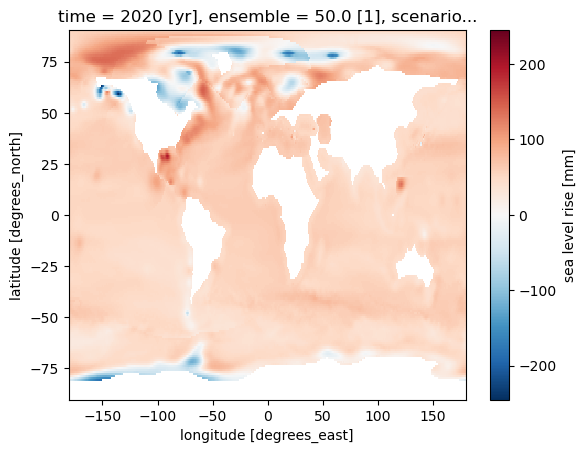

<IPython.core.display.Javascript object>

In [39]:
data = rio.open_rasterio(outpath, masked=True)
#data.plot()
rds.plot()

#### Multiple CoGs

In [54]:
# do for all CoGs (CF compliant)

# open the dataset
ds_fp = ds_dir.joinpath(ds_out_file + "_CF.nc")
ds = xr.open_dataset(ds_fp)

for idx, scen in enumerate(ds["scenarios"].values):
    ssp = scen.decode("utf-8")

    # format rcp name for filenaming
    ssp_name = "ssp=%s"%ssp.strip("SSP")
    print(ssp_name)

    # extract list of data variables
    variables = set(ds.variables) - set(ds.dims) - set(ds.coords)
    #print(variables)

    ntimes = ds.dims["time"]
    for ntime in range(ntimes):
        ds2 = ds.copy()
        ds2 = ds2.isel({"time": ntime})

        # extract time for use tif naming (dataset specific)
        time_name = str(ds2.time.values)

        for var_name in variables:
            da = ds2.sel({"nscenarios": idx})[var_name]

            for idv, ens in enumerate(da["ensemble"].values):
                da2 = da.isel({"ensemble": idv})

                # add crs and spatial dims
                da2.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
                if not da2.rio.crs:
                    da2 = da2.rio.write_crs("EPSG:4326")

                # compose tif name
                fname = time_name + ".tif"
                blob_name = pathlib.Path(ssp_name, var_name + "_ens%s"%np.around(ens, decimals=2), fname)
                outpath = cog_dirs.joinpath(blob_name)

                # convert to dataset and save as geotiff & nc to check the CF compliancy
                # dads = da2.to_dataset()

                # # add all attributes (again)
                # for attr_name, attr_val in meta_global.items():
                #     if attr_name == 'PROVIDERS':
                #         attr_val = json.dumps(attr_val)
                #     if attr_name == "MEDIA_TYPE": # change media type to tiff, leave the rest as is
                #         attr_val = "IMAGE/TIFF"
                #     dads.attrs[attr_name] = attr_val

                # dads.attrs['Conventions'] = "CF-1.8"

                # save to .nc & geotiff
                # fname = f"{var_name}_{ssp}_ens{np.around(ens, decimals=2)}_time{ntime}_CF.GeoTiff"
                # outpath = cog_dir.joinpath(fname)
                # dads.rio.to_raster(outpath, driver="GTiff")
                # dads.to_netcdf(path=cog_dir.joinpath(fname.replace(".GeoTiff", ".nc")))
                # CF_dir = coclico_data_dir.joinpath(r"CF")
                
                # make parent dir if not exists
                outpath.parent.mkdir(parents=True, exist_ok=True)

                # set overwrite is false because tifs should be unique
                try:
                    write_cog(da2, fname=outpath, overwrite=False)
                except OSError as e:
                    continue

ssp=1-26


In [51]:
# %%capture cap --no-stderr
# # check original CF compliancy

# check_compliancy(testfile=cog_dir.joinpath(fname.replace(".GeoTiff", ".nc")), working_dir=CF_dir)

<IPython.core.display.Javascript object>

In [52]:
# save original CF compliancy
# save_compliancy(cap, testfile=cog_dir.joinpath(fname.replace(".GeoTiff", ".nc")), working_dir=CF_dir)

{'P:\\11205479-coclico\\FASTTRACK_DATA\\17_AR6_SLP_IPCC\\cog\\slr_SSP1-26_ens0.0_time0_CF.nc': {'warnings': '0', 'errors': '0'}}


<IPython.core.display.Javascript object>